### **Assignment #7-8**

In this assignment, you will familiarize yourself with a typical neural network training
and evaluation workflow. You will construct a dataset framework for batched training,
create your own implementations of common neural network operations, and train
your model on the Fashion-MNIST dataset. You will accomplish this in the PyTorch
environment. To use PyTorch install the API on your local machine.¸


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn

In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


First, load the Fashion-MNIST dataset from the Fashion-MNIST GitHub repository.
Use the provided utils.mnist_reader class to load the training data, which should
contain 60000 training samples. Then, normalize the training sample values to the
range [0, 1] and visualize one random member from each of the 10 classes.



Split the data into two subsets: a training subset and a validation subset, where the
latter constitutes of 20 percent random samples from the entire data set. Reshape the
sample data in both subsets such that each sample corresponds to a two-dimensional
image with a single channel. The dimensions of each subset should be equal to
[N, 1, 28, 28], where N denotes the total number of samples in the subset. Convert
both the samples and the labels of both subsets to PyTorch Tensors, where you
additionally transform the class labels to one-hot encodings.


In [284]:
X_train, y_train = load_mnist('', kind='train')
X_test, y_test = load_mnist('', kind='t10k')
x_train = X_train.reshape((60000, 1, 28, 28))/255.0 #
labels = np.zeros((60000, 10))
labels[np.arange(60000), y_train] = 1 # one-hot
split = int(len(x_train)*0.2)
train_samples = torch.Tensor(x_train[:-split])
train_labels = torch.Tensor(labels[:-split])
val_samples = torch.Tensor(x_train[-split:])
val_labels = torch.Tensor(labels[-split:])

x_test = X_test.reshape((10000, 1, 28, 28))/255.0 #
labels2 = np.zeros((10000, 10))
labels2[np.arange(10000), y_test] = 1 # one-hot
test_samples = torch.Tensor(x_test)
test_labels = torch.Tensor(labels2)

In [285]:
labels_map = ["t-shirt/top", "trousers", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]

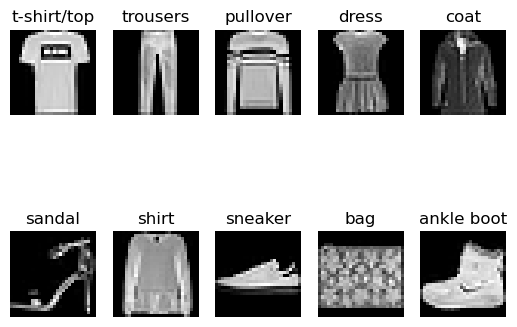

In [286]:
i = 1
for idx in [1, 16, 5, 3, 19, 8, 18, 6, 23, 0]:
    plt.subplot(2, 5, i)
    i+=1
    plt.imshow(x_train[idx][0], 'gray')
    plt.axis('off')
    plt.title(labels_map[y_train[idx]])
plt.show()

 Then, define the
following Python class and fill out its class methods:

In [225]:
class Dataset():
    def __init__(self, samples, labels, batch_size, shuffle):
        self.samples = samples
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = list(range(len(self.samples)))
        if shuffle:
            self.shuffle()

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        batch_samples = self.samples[batch_indexes]
        batch_labels = self.labels[batch_indexes]
        return batch_samples, batch_labels

    def __len__(self):
         return (len(self.samples) + self.batch_size - 1) // self.batch_size

    def shuffle(self):
        random.shuffle(self.indexes)

In [226]:
data = Dataset(train_samples, train_labels, 16, True)

data[0][0].shape, data[0][0].dtype

(torch.Size([16, 1, 28, 28]), torch.float32)

Now, we will implement three basic operations that will serve as the backbone of our
classification neural network. These operations are: two-dimensional convolution,
two-dimensional max pooling, and the element-wise Linear Rectified Unit.

Use the class constructors to do the necessary function orchestration and implement
the actual operation of the input sample x in the forward method. For more details
on the individual functions and their arguments consult the PyTorch documentation: Conv2d, MaxPool2d, ReLU. The convolution and maximal pooling operations should provide no padding to the input.

Use the dataset implementation from the previous exercises to test your model.
Do not use the PyTorch implementations of these functions (torch.nn.Conv2d,
torch.nn.MaxPool2d, torch.nn.ReLU) instead of implementing the functions yourselves!

In [253]:
# testing out shapes
a = torch.randn(16, 676, 9)
b = torch.randn(64, 9)
print(a.size())
print(b.size())
res = torch.matmul(a, b.t())
print(res.size())

torch.Size([16, 676, 9])
torch.Size([64, 9])
torch.Size([16, 676, 64])


In [263]:
class Conv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, test=False):
        super().__init__()
        self.in_c = in_channels
        self.out_c = out_channels
        self.k_s = kernel_size
        self.stride = stride
        self.test = test

        self.weight = torch.nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = torch.nn.Parameter(torch.randn(out_channels))
        

    def forward(self, x):
        batch_size, tmp, input_height, input_width = x.size()

        output_height = (input_height - self.k_s) // self.stride + 1
        output_width = (input_width - self.k_s) // self.stride + 1
        
        unfolded = torch.nn.functional.unfold(x, self.k_s, padding=0, stride=self.stride).transpose(1, 2)

        output = torch.matmul(unfolded, self.weight.reshape(self.out_c, -1).t()) + self.bias

        out1 = output.transpose(1, 2).reshape(batch_size, self.out_c, output_height, output_width)

        if self.test:
            out2 = torch.nn.functional.conv2d(x, self.weight, bias=self.bias, stride=self.stride, padding=0)
            return out1, out2
        else:
            return out1
    
class MaxPool2d(torch.nn.Module):
    def __init__(self, kernel_size, stride, test=False):
        super().__init__()

        self.test = test
        self.k_s = kernel_size
        self.stride = stride

    def forward(self, x):
        batch_size, channels, input_height, input_width = x.size()

        output_height = (input_height - self.k_s) // self.stride + 1
        output_width = (input_width - self.k_s) // self.stride + 1

        unfolded = torch.nn.functional.unfold(x, self.k_s, padding=0, stride=self.stride)

        output, _ = unfolded.reshape(batch_size, channels, self.k_s*self.k_s, -1).max(dim=2)

        out1 = output.reshape(batch_size, channels, output_height, output_width)
        if self.test:
            return out1, torch.nn.functional.max_pool2d(x, kernel_size=self.k_s, stride=self.stride, padding=0)
        else:
            return out1

class ReLU(torch.nn.Module):
    def __init__(self, test=False):
        super().__init__()
        self.test = test

    def forward(self, x):
        # Apply element-wise ReLU activation
        if self.test:
            return x.clamp_(min=0.0), torch.nn.functional.relu(x)
        else:
            return x.clamp_(min=0.0)
        

After you have completed each function’s implementation make sure that
they perform the same as their PyTorch counterparts: torch.nn.Conv2d,
torch.nn.MaxPool2d, and torch.nn.ReLU. Pass the same input through the corresponding functions and observe the pixel-wise absolute difference. The maximal
difference should be smaller than $10^{-5}$
. When comparing the convolution operations
make sure that both functions contain the same weight and bias tensors (the weight
and bias property of the convolution class).

In [266]:
conv = Conv2d(1, 64, 3, 1, test=True)
t1, t2 = conv.forward(data[0][0])
torch.allclose(t1,t2, rtol=1e-5, atol=1e-5)

True

In [267]:
m = MaxPool2d(3, 2, test=True)
tm1, tm2 = m.forward(data[0][0])
torch.allclose(tm1,tm2, rtol=1e-5, atol=1e-5)

True

In [268]:
r = ReLU(test=True)
tr1, tr2 = r.forward(data[0][0])
torch.allclose(tr1, tr2, rtol=1e-5, atol=1e-5)

True

In [269]:
import torch.profiler as profiler
custom_conv = Conv2d(64, 64, 3, 1)

# Create dummy input tensor
dummy_input = torch.randn(16, 64, 12, 12)

# Run a forward pass inside the profiler
with profiler.profile(record_shapes=True, use_cuda=False) as prof:
    with profiler.record_function("forward_pass"):
        output = custom_conv(dummy_input)

# Print the profiling results
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
            forward_pass        25.93%       2.352ms       100.00%       9.069ms       9.069ms             1  
            aten::im2col        31.41%       2.849ms        35.29%       3.200ms       3.200ms             1  
            aten::matmul         1.80%     163.000us        33.42%       3.031ms       3.031ms             1  
           aten::reshape         0.61%      55.000us        19.79%       1.795ms     598.333us             3  
             aten::clone         0.20%      18.000us        18.34%       1.663ms       1.663ms             1  
             aten::copy_        17.86%       1.620ms        17.86%       1.620ms       1.620ms             1  
 

For this exercise, use the classes you constructed in the previous exercises.

We will briefly examine how the ordering of operations inside the neural network
affects the output. We will look at the specific case of MaxPool2d and ReLU commutativity. Create a PyTorch tensor with random elements in the range [−1, 1] of
dimensions [1, 100, 100]. Pass the tensor through two different transformations individually:

- Function one: MaxPool2d(kernel_size = 3, stride = 2) followed by ReLU
- Function two: ReLU followed by MaxPool2d(kernel_size = 3, stride = 2)

Compare the outputs of the two sets. What did you observe? Explain the obtained
results mathematically and think about the implications of this observation. Is the
same true if we replace the maximal pooling operation with a convolution?

In [270]:
input_tensor = torch.rand(1, 1, 100, 100)*2 - 1
input_tensor.size(), input_tensor.min(), input_tensor.max()

(torch.Size([1, 1, 100, 100]), tensor(-0.9999), tensor(0.9999))

In [271]:
r = ReLU()
m = MaxPool2d(3, 2)
out1 = r.forward(m.forward(input_tensor))
out2 = m.forward(r.forward(input_tensor))
torch.allclose(out1, out2) # ???

True

In [272]:
r = ReLU()
c = Conv2d(1, 64, 3, 1)
out1 = r.forward(c.forward(input_tensor))
out2 = c.forward(r.forward(input_tensor))
torch.allclose(out1, out2) # ???

False

For this exercise, use the classes you constructed in the previous exercises.

Now, we will define a neural network using the custom functions from previous exercises. This network will produce a vector of 10 elements for each sample, predicting
the class it belongs to. Our neural network will consist of the following basic blocks:
- Conv2d followed by MaxPool2d followed by ReLU

There should be two such blocks in your network, one following the other. The kernel size of both the convolution and maximal pooling layers in both blocks should
be equal to 3. The output of the second block should be a tensor with the following
dimensions: [B, 64, 4, 4], where B is the batch size and 64 is the number of channels.
You have to determine the appropriate remaining hyperparameters for the blocks to
produce an output of such shape.

Finally, your model should end with a single convolution layer with a kernel_size
of 4 which will produce 10 output channels. The output of this layer should therefore be a tensor with a dimension equal to [B, 10, 1, 1]. Apply a flatten operation
(torch.nn.Flatten) on the last layer’s output to generate the output of size: [B, 10].

Create the same neural network architecture, but use the built-in PyTorch classes:
torch.nn.Conv2d, torch.nn.MaxPool2d, torch.nn.ReLU.

- Use the torch.nn.Sequential module to store the functions into one operation!

In [273]:
from torch import nn
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            Conv2d(1, 64, 3, 1),
            MaxPool2d(3, 2),
            ReLU(),
            Conv2d(64, 64, 3, 1),
            MaxPool2d(3, 2),
            ReLU(),
            Conv2d(64, 10, 4, 1),
            nn.Flatten(),
        )

    def forward(self, x):
        x = self.network(x)

        return x

class TorchModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            nn.MaxPool2d(3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.MaxPool2d(3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 10, 4, 1),
            nn.Flatten(),
        )

    def forward(self, x):
        x = self.network(x)

        return x

For this exercise, use the models you constructed in the previous exercises.
Lets put it all together! Using the Stochastic Gradient Descent algorithm and the
Cross-Entropy loss function define a function fit, which takes in two parameters: the
model you wish to fit and the number of epochs, denoting the number of times you
will iterate over the training and validation datasets.

Train both models from the previous exercise (your custom model and the PyTorch
equivalent) for 10 epochs. The fit function should return the model that best performed on the validation dataset during training and a list of 10 training and validation losses, one for each epoch.

Visualize the training and validation losses for all 10 epochs and both models. Is
there a difference in performance? Account for the various potential sources of these
differences.

- You can use the torch.optim.SGD and torch.nn.CrossEntropyLoss classes for the Stochastic Gradient Descent and the Cross-Entropy loss function.
- Be careful that you select the best model at the end of each epoch and not when you iterate through all the epochs.

In [274]:
import torch
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

def fit(model, num_epochs=10):
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
  
    train_data = Dataset(train_samples, train_labels, batch_size=64, shuffle=True)
    train_loader = DataLoader(train_data, batch_size=None, shuffle=True)

    val_data = Dataset(val_samples, val_labels, batch_size=64, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=None, shuffle=False)

    # Optimizer and Loss function
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    for epoch in range(num_epochs):
        print(f"Doing epoch num.{epoch} .", end='')
        model.train()
        epoch_train_loss = 0.0
        #i = 0
        for inputs, labels in train_loader:
            #print(i)
            #i+=1
            #print(inputs.size())
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        print(".", end='')
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(".", end='')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
        print("Done")

    model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

t_model = TorchModel()
best_torch_model, torch_train_losses, torch_val_losses = fit(t_model, num_epochs=10)
my_model = MyModel()
my_b_model, my_train_loss, my_val_loss = fit(my_model, 10)

Doing epoch num.0 ...Done
Doing epoch num.1 ...Done
Doing epoch num.2 ...Done
Doing epoch num.3 ...Done
Doing epoch num.4 ...Done
Doing epoch num.5 ...Done
Doing epoch num.6 ...Done
Doing epoch num.7 ...Done
Doing epoch num.8 ...Done
Doing epoch num.9 ...Done
Doing epoch num.0 ...Done
Doing epoch num.1 ...Done
Doing epoch num.2 ...Done
Doing epoch num.3 ...Done
Doing epoch num.4 ...Done
Doing epoch num.5 ...Done
Doing epoch num.6 ...Done
Doing epoch num.7 ...Done
Doing epoch num.8 ...Done
Doing epoch num.9 ...Done


In [278]:
torch_train_losses, torch_val_losses

([0.6602731881936391,
  0.41807279203335446,
  0.3675984105269114,
  0.3360014565885067,
  0.31389804467558863,
  0.2975240952670574,
  0.2844753702580929,
  0.2781060575445493,
  0.26550968622167903,
  0.25815950279434524],
 [0.45036236196756363,
  0.4166291538388171,
  0.3461497738323313,
  0.33744469709060293,
  0.3317629360851455,
  0.30740716601622864,
  0.3176419599813984,
  0.29403726336486796,
  0.3270004951652694,
  0.31844388356709735])

In [277]:
my_train_loss, my_val_loss

([25.148781372070314,
  2.303018072128296,
  2.3029838879903157,
  2.3030125099817913,
  2.3028563203811645,
  2.3030741504033405,
  2.3030727682113645,
  2.3030004634857177,
  2.3029848108291624,
  2.302921337445577],
 [2.303063284843526,
  2.3026263853336904,
  2.303208475417279,
  2.303325541475986,
  2.3034122713068697,
  2.3029482161745114,
  2.303098720438937,
  2.30262154974836,
  2.3027704117145946,
  2.30387186243179])

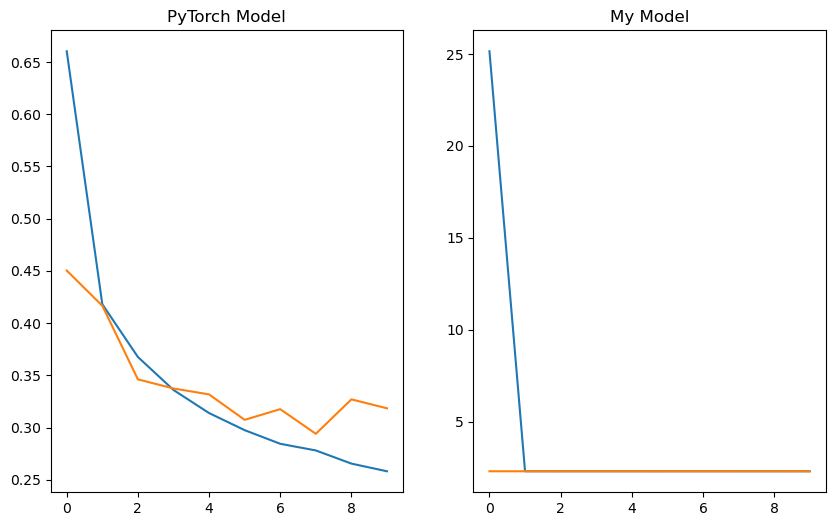

In [279]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(torch_train_losses)
plt.plot(torch_val_losses)
plt.title("PyTorch Model")
plt.subplot(1, 2, 2)
plt.plot(my_train_loss)
plt.plot(my_val_loss)
plt.title("My Model")
plt.show()

In [ ]:
comment = """I think the difference is in how the initial weights and bias are set? We tested above
            that at the same weights and bias the results of both my implementation and torches is the same."""

**BONUS:**

For this exercise, use the fit function and dataset class you constructed in the previous
exercises.

Create a custom neural network model using PyTorch functions and fit the model to
the training data. Optimize the neural network hyperparameters (number of layers,
kernel size, etc...) to get the best results on the validation dataset.
Evaluate your prediction on the validation dataset using the performance.plot_stats
function (included in the assignment materials) which takes as input your model’s
predictions and the corresponding correct labels (both in one-hot encoding format
and numpy ndarrays). The output of the function is the image titled stats.png, containing the class confusion matrix, and the macro recall and macro precision values
for each class.

Explain the results you observe. What is the most challenging class to classify? Why

In [289]:
import performance as p
#test_data = Dataset(test_samples, test_labels, batch_size=64, shuffle=False)
#test_loader = DataLoader(test_data, batch_size=None, shuffle=False)

best_torch_model.eval()

with torch.no_grad():
    predictions = best_torch_model(test_samples)
    print(predictions)


tensor([[ -4.4712,  -8.7544,  -3.2057,  ...,   6.4506,   1.7348,  11.0716],
        [  5.2410,  -3.0861,   9.7634,  ..., -10.4980,  -1.2854,  -6.7243],
        [  0.9716,  14.9135,  -2.1789,  ..., -11.4993,   4.0475,  -6.6052],
        ...,
        [  1.4615,  -5.6534,   0.8813,  ...,  -6.5904,  10.3054,  -6.9298],
        [ -0.7380,  11.8201,  -3.1907,  ...,  -6.0135,  -0.9243,  -4.1491],
        [ -1.5073,  -5.3268,   0.6376,  ...,   3.9032,   1.5289,  -0.7953]])


In [290]:
predictions.size()

torch.Size([10000, 10])

In [292]:
p.plot_stats(predictions, test_labels, labels_map)